NB with ANOVA (try with chi)

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_selection import RFE
from imblearn.under_sampling import RandomUnderSampler
import os
import joblib
import time
import psutil

# Start measuring time and resources
start_time = time.time()
process = psutil.Process(os.getpid())
start_memory = process.memory_info().rss / (1024 ** 2)  # Convert to MB
start_cpu_times = process.cpu_times()

# Load the dataset
df = pd.read_csv(r'C:\Users\arell\Documents\1_ALF\data\malicious_2021.csv', low_memory=False)

# Select features and target columns
features = ['Querylength', 'domain_token_count', 'path_token_count', 'avgdomaintokenlen', 'longdomaintokenlen', 
            'avgpathtokenlen', 'tld', 'charcompvowels', 'charcompace', 'ldl_url', 'ldl_domain', 'ldl_path', 
            'ldl_filename', 'ldl_getArg', 'subDirLen', 'this.fileExtLen', 'ArgLen', 'pathurlRatio', 
            'ArgUrlRatio', 'argDomanRatio', 'domainUrlRatio', 'pathDomainRatio', 'argPathRatio', 'executable', 
            'isPortEighty', 'NumberofDotsinURL', 'ISIpAddressInDomainName', 'CharacterContinuityRate', 
            'LongestVariableValue', 'URL_DigitCount', 'host_DigitCount', 'Directory_DigitCount', 
            'File_name_DigitCount', 'Extension_DigitCount', 'Query_DigitCount', 'URL_Letter_Count', 
            'host_letter_count', 'Directory_LetterCount', 'Filename_LetterCount', 'Extension_LetterCount', 
            'Query_LetterCount', 'LongestPathTokenLength', 'Domain_LongestWordLength', 'Path_LongestWordLength', 
            'sub-Directory_LongestWordLength', 'Arguments_LongestWordLength', 'URL_sensitiveWord', 
            'URLQueries_variable', 'spcharUrl', 'delimeter_Domain', 'delimeter_path', 'delimeter_Count', 
            'NumberRate_URL', 'NumberRate_Domain', 'NumberRate_DirectoryName', 'NumberRate_FileName', 
            'NumberRate_Extension', 'NumberRate_AfterPath', 'SymbolCount_URL', 'SymbolCount_Domain', 
            'SymbolCount_Directoryname', 'SymbolCount_FileName', 'SymbolCount_Extension', 'SymbolCount_Afterpath', 
            'Entropy_URL', 'Entropy_Domain', 'Entropy_Filename', 'Entropy_Extension', 'Entropy_Afterpath']

# Clean the dataset
df_cleaned = df.copy()
df_cleaned['tld'] = df_cleaned['tld'].astype(str)
df_cleaned['url_type'] = df_cleaned['url_type'].astype(str)

numeric_features = [f for f in features if f not in ['tld', 'url_type']]
df_cleaned = df_cleaned[np.isfinite(df_cleaned[numeric_features]).all(axis=1)]

# Encode categorical features
label_encoder_tld = LabelEncoder()
label_encoder_url_type = LabelEncoder()
df_cleaned['tld_encoded'] = label_encoder_tld.fit_transform(df_cleaned['tld'])
df_cleaned['url_type_encoded'] = label_encoder_url_type.fit_transform(df_cleaned['url_type'])

# Set up features and binary labels
X = df_cleaned[numeric_features + ['tld_encoded']]
y_binary = df_cleaned['binary_label'] = df_cleaned['url_type'].apply(lambda x: 0 if x == 'benign' else 1)

# Multiclass labels
y_multiclass = df_cleaned['url_type_encoded']

# RFE for feature selection
dt_classifier = DecisionTreeClassifier(random_state=42)
rfe_selector = RFE(estimator=dt_classifier, n_features_to_select=25)
X_selected = rfe_selector.fit_transform(X, y_binary)
selected_features = [numeric_features[i] for i in range(len(numeric_features)) if rfe_selector.support_[i]]

# Undersampling for binary classification
under_sampler = RandomUnderSampler(sampling_strategy={label: 40000 for label in y_binary.unique()}, random_state=42)
X_resampled_binary, y_resampled_binary = under_sampler.fit_resample(X_selected, y_binary)

# Binary classification
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(
    X_resampled_binary, y_resampled_binary, test_size=0.3, random_state=42, stratify=y_resampled_binary
)

dt_classifier.fit(X_train_binary, y_train_binary)
y_pred_binary = dt_classifier.predict(X_test_binary)

print("Binary Classification Report:")
print(classification_report(y_test_binary, y_pred_binary))

# Multiclass classification for malicious URLs
malicious_idx = np.where(y_pred_binary == 1)[0]
X_malicious = X_test_binary[malicious_idx]
y_malicious = y_multiclass.iloc[malicious_idx]

dt_classifier.fit(X_resampled_binary[malicious_idx], y_malicious)
y_pred_multiclass = dt_classifier.predict(X_malicious)

print("Multiclass Classification Report:")
print(classification_report(y_malicious, y_pred_multiclass))

# Resource usage
end_time = time.time()
end_memory = process.memory_info().rss / (1024 ** 2)
end_cpu_times = process.cpu_times()

print(f"Execution Time: {end_time - start_time:.2f} seconds")
print(f"Memory Used: {end_memory - start_memory:.2f} MB")
print(f"CPU Times - User: {end_cpu_times.user - start_cpu_times.user:.2f}s, "
      f"System: {end_cpu_times.system - start_cpu_times.system:.2f}s")


Binary Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     12000
           1       0.94      0.94      0.94     12000

    accuracy                           0.94     24000
   macro avg       0.94      0.94      0.94     24000
weighted avg       0.94      0.94      0.94     24000

Multiclass Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.59      0.65      8796
           1       0.19      0.27      0.22      2208
           2       0.04      0.03      0.03       305
           3       0.06      0.13      0.08       689

    accuracy                           0.49     11998
   macro avg       0.25      0.25      0.25     11998
weighted avg       0.58      0.49      0.52     11998

Execution Time: 959.44 seconds
Memory Used: -691.85 MB
CPU Times - User: 883.12s, System: 3.69s


In [7]:
# Get a boolean mask of selected features
mask = anova_selector.get_support()

# Extract the names of selected features
selected_features = np.array(X.columns)[mask]

print("Selected Features:")
for feature in selected_features:
    print(f"- {feature}")


Selected Features:
- domain_token_count
- path_token_count
- avgdomaintokenlen
- longdomaintokenlen
- ldl_domain
- ldl_path
- subDirLen
- pathurlRatio
- argDomanRatio
- domainUrlRatio
- NumberofDotsinURL
- host_letter_count
- Directory_LetterCount
- Domain_LongestWordLength
- URLQueries_variable
- delimeter_Domain
- delimeter_Count
- NumberRate_Domain
- SymbolCount_Domain
- Entropy_Domain


DT with RFE

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_selection import RFE
from imblearn.under_sampling import RandomUnderSampler
import os
import joblib
import time
import psutil

# Load the dataset
df = pd.read_csv(r'C:\Users\arell\Documents\1_ALF\data\malicious_2021.csv', low_memory=False)

# Start measuring time and resources
process = psutil.Process(os.getpid())
start_time = time.time()
start_memory = process.memory_info().rss / (1024 ** 2)  # Convert to MB
start_cpu_times = process.cpu_times()

# Select features and target columns
features = ['Querylength', 'domain_token_count', 'path_token_count', 'avgdomaintokenlen', 'longdomaintokenlen', 
            'avgpathtokenlen', 'tld', 'charcompvowels', 'charcompace', 'ldl_url', 'ldl_domain', 'ldl_path', 
            'ldl_filename', 'ldl_getArg', 'subDirLen', 'this.fileExtLen', 'ArgLen', 'pathurlRatio', 
            'ArgUrlRatio', 'argDomanRatio', 'domainUrlRatio', 'pathDomainRatio', 'argPathRatio', 'executable', 
            'isPortEighty', 'NumberofDotsinURL', 'ISIpAddressInDomainName', 'CharacterContinuityRate', 
            'LongestVariableValue', 'URL_DigitCount', 'host_DigitCount', 'Directory_DigitCount', 
            'File_name_DigitCount', 'Extension_DigitCount', 'Query_DigitCount', 'URL_Letter_Count', 
            'host_letter_count', 'Directory_LetterCount', 'Filename_LetterCount', 'Extension_LetterCount', 
            'Query_LetterCount', 'LongestPathTokenLength', 'Domain_LongestWordLength', 'Path_LongestWordLength', 
            'sub-Directory_LongestWordLength', 'Arguments_LongestWordLength', 'URL_sensitiveWord', 
            'URLQueries_variable', 'spcharUrl', 'delimeter_Domain', 'delimeter_path', 'delimeter_Count', 
            'NumberRate_URL', 'NumberRate_Domain', 'NumberRate_DirectoryName', 'NumberRate_FileName', 
            'NumberRate_Extension', 'NumberRate_AfterPath', 'SymbolCount_URL', 'SymbolCount_Domain', 
            'SymbolCount_Directoryname', 'SymbolCount_FileName', 'SymbolCount_Extension', 'SymbolCount_Afterpath', 
            'Entropy_URL', 'Entropy_Domain', 'Entropy_Filename', 'Entropy_Extension', 'Entropy_Afterpath']

# Clean the dataset by removing NaNs and infinities in numeric columns only
df_cleaned = df.copy()
df_cleaned['tld'] = df_cleaned['tld'].astype(str)
df_cleaned['url_type'] = df_cleaned['url_type'].astype(str)

numeric_features = [f for f in features if f not in ['tld', 'url_type']]
df_cleaned = df_cleaned[np.isfinite(df_cleaned[numeric_features]).all(axis=1)]

# Encode 'tld' and 'url_type'
label_encoder_tld = LabelEncoder()
label_encoder_url_type = LabelEncoder()
df_cleaned['tld_encoded'] = label_encoder_tld.fit_transform(df_cleaned['tld'])
df_cleaned['url_type_encoded'] = label_encoder_url_type.fit_transform(df_cleaned['url_type'])

# Set up features and labels
X = df_cleaned[numeric_features + ['tld_encoded']]
y = df_cleaned['binary_label'] = df_cleaned['url_type'].apply(lambda x: 0 if x == 'benign' else 1)

# Select features including both numeric and encoded categorical features
all_features = numeric_features + ['tld_encoded']

# Apply RFE for feature selection
dt_classifier = DecisionTreeClassifier(random_state=42)
rfe_selector = RFE(estimator=dt_classifier, n_features_to_select=25)
X_selected = rfe_selector.fit_transform(X[all_features], y)

# Get the selected feature names
selected_features = [all_features[i] for i in range(len(all_features)) if rfe_selector.support_[i]]
X_selected_df = pd.DataFrame(X_selected, columns=selected_features)

# Apply undersampling to balance classes at 40,000 samples per URL type
under_sampler = RandomUnderSampler(sampling_strategy={label: 40000 for label in y.unique()}, random_state=42)
X_resampled, y_resampled = under_sampler.fit_resample(X_selected_df, y)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)

# Initialize and fit the Decision Tree classifier for binary classification
dt_classifier.fit(X_train, y_train)

# Predictions for Binary Classification
y_train_pred = dt_classifier.predict(X_train)
y_test_pred = dt_classifier.predict(X_test)

# Classification reports
print("Binary Classification Report - Training Data:")
print(classification_report(y_train, y_train_pred))
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))

print("\nBinary Classification Report - Test Data:")
print(classification_report(y_test, y_test_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

# Multiclass Classification for malicious URL types
malicious_df = df_cleaned[df_cleaned['binary_label'] == 1].copy()

# Reapply feature selection for the multiclass problem
X_multi = malicious_df[all_features]  # Use all features for selection again
y_multi = malicious_df['url_type_encoded']

# Apply RFE specifically for multiclass feature selection
rfe_selector_multi = RFE(estimator=dt_classifier, n_features_to_select=25)  # Adjust n_features_to_select as needed
X_multi_selected = rfe_selector_multi.fit_transform(X_multi, y_multi)

# Get the selected features for multiclass
selected_features_multi = [all_features[i] for i in range(len(all_features)) if rfe_selector_multi.support_[i]]
X_multi_selected_df = pd.DataFrame(X_multi_selected, columns=selected_features_multi)

# Train-Test Split for Multiclass
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi_selected_df, y_multi, test_size=0.4, random_state=42, stratify=y_multi
)

# Train the Decision Tree classifier for Multiclass
dt_multiclass_classifier = DecisionTreeClassifier(random_state=42)
dt_multiclass_classifier.fit(X_train_multi, y_train_multi)

# Predictions and Evaluations for Multiclass
y_train_pred_multi = dt_multiclass_classifier.predict(X_train_multi)
y_test_pred_multi = dt_multiclass_classifier.predict(X_test_multi)

# Print classification reports for Multiclass
print("Multiclass Classification Report (Training):")
print(classification_report(y_train_multi, y_train_pred_multi))
print("Multiclass Classification Report (Test):")
print(classification_report(y_test_multi, y_test_pred_multi))

# Accuracy Summary
train_accuracy_bin = accuracy_score(y_train, y_train_pred)
test_accuracy_bin = accuracy_score(y_test, y_test_pred)
train_accuracy_multi = accuracy_score(y_train_multi, y_train_pred_multi)
test_accuracy_multi = accuracy_score(y_test_multi, y_test_pred_multi)

print(f"Binary Classification - Train Accuracy: {train_accuracy_bin:.4f}")
print(f"Binary Classification - Test Accuracy: {test_accuracy_bin:.4f}")
print(f"Multiclass Classification - Train Accuracy: {train_accuracy_multi:.4f}")
print(f"Multiclass Classification - Test Accuracy: {test_accuracy_multi:.4f}")

# End measuring time and resources
end_time = time.time()
end_memory = process.memory_info().rss / (1024 ** 2)  # Convert to MB
end_cpu_times = process.cpu_times()

# Print execution time and resource usage
print(f"\nExecution Time: {end_time - start_time:.2f} seconds")
print(f"Memory Used: {end_memory - start_memory:.2f} MB")
print(f"CPU Times - User: {end_cpu_times.user - start_cpu_times.user:.2f}s, "
      f"System: {end_cpu_times.system - start_cpu_times.system:.2f}s")



Binary Classification Report - Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28000
           1       1.00      1.00      1.00     28000

    accuracy                           1.00     56000
   macro avg       1.00      1.00      1.00     56000
weighted avg       1.00      1.00      1.00     56000

Training Accuracy: 0.9998035714285715

Binary Classification Report - Test Data:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     12000
           1       0.94      0.94      0.94     12000

    accuracy                           0.94     24000
   macro avg       0.94      0.94      0.94     24000
weighted avg       0.94      0.94      0.94     24000

Test Accuracy: 0.9419166666666666
Multiclass Classification Report (Training):
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     57874
           2       1.00      0.


Execution Time: 0.00 seconds
Memory Used: 0.00 MB
CPU Times - User: 0.00s, System: 0.00s


In [3]:
# Get the selected feature names for binary classification
binary_selected_features = [all_features[i] for i in range(len(all_features)) if rfe_selector.support_[i]]

print("Selected Features for Binary Classification:")
for feature in binary_selected_features:
    print(f"- {feature}")


Selected Features for Binary Classification:
- domain_token_count
- avgpathtokenlen
- charcompvowels
- ldl_url
- ldl_domain
- ldl_path
- ldl_filename
- subDirLen
- pathurlRatio
- domainUrlRatio
- NumberofDotsinURL
- CharacterContinuityRate
- URL_DigitCount
- host_DigitCount
- URL_Letter_Count
- Filename_LetterCount
- Path_LongestWordLength
- sub-Directory_LongestWordLength
- delimeter_Count
- NumberRate_URL
- SymbolCount_URL
- SymbolCount_Directoryname
- Entropy_URL
- Entropy_Filename
- Entropy_Extension


Binary Confusion Matrix (Test):
[[11194   806]
 [ 3881  8119]]


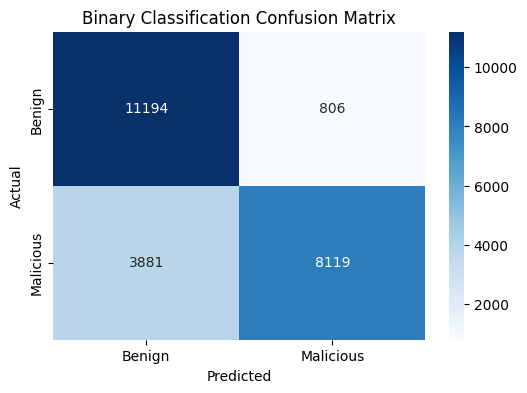

Multiclass Confusion Matrix (Test):
[[36928   668   987]
 [ 4392  7795   821]
 [ 5686  1589 30370]]


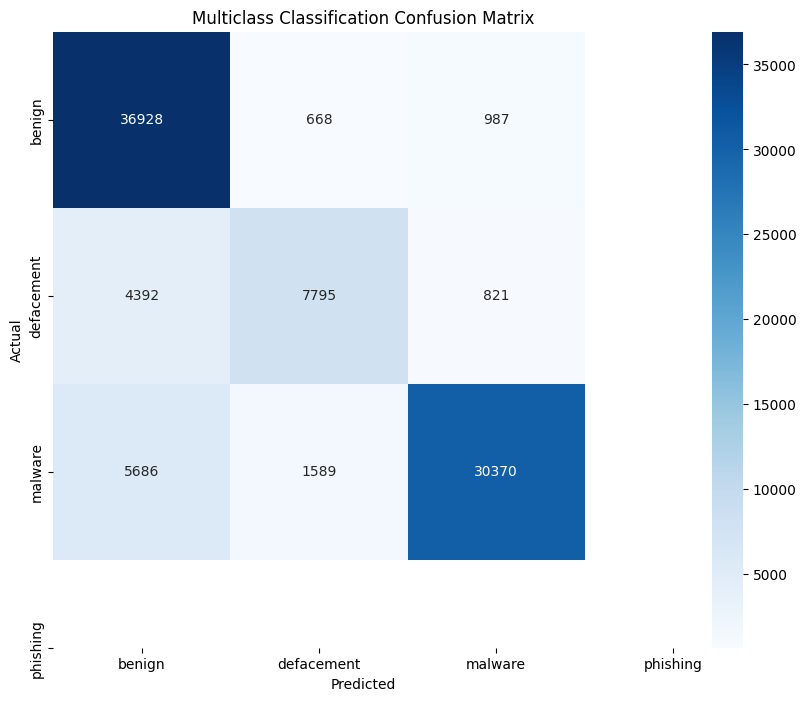

In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Binary Confusion Matrix
binary_conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Binary Confusion Matrix (Test):")
print(binary_conf_matrix)

# Plot Binary Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(binary_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
plt.title("Binary Classification Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Multiclass Confusion Matrix
multi_conf_matrix = confusion_matrix(y_test_multi, y_test_pred_multi)
print("Multiclass Confusion Matrix (Test):")
print(multi_conf_matrix)

# Plot Multiclass Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(multi_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder_url_type.classes_, yticklabels=label_encoder_url_type.classes_)
plt.title("Multiclass Classification Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
